In [ ]:
import os

import numpy as np
import plotly.graph_objects as go
from numpy.polynomial import Polynomial
from plotly.subplots import make_subplots

from src.flarepy_DS_Tuc_A import FlareDetector_DS_Tuc_A

In [ ]:
print(os.getcwd())  # 現在のディレクトリを表示

# EK_Dra のデータ１つに対してインスタンスを作成

- for ループで回してグラフを表示できるように辞書の中にインタンスを入れる
- 辞書のキーはファイル名から取得する
- 全ての計算処理は、インスタンス生成時に自動で行えるようにする。
- 途中の計算結果の配列は、インスタンス変数として全て保持するように`flarepy_improved.py`を変更した。
- 観測時間順に辞書をソートして、後で for ループで回してグラフを表示する際に観測時間順に表示できるようにする。


In [ ]:
# "EK_Dra" フォルダーのパス。上の`print(os.getcwd())`の結果を参考に各自自分の環境に合わせて変更してください。
folder_path = "../data/TESS/DS_Tuc_A"

# フォルダー内のファイルリストにフルパスを格納(リスト内包表記を使用)
file_list = [os.path.join(folder_path, file_name) for file_name in os.listdir(folder_path)]

# FlareDetectorインスタンスを格納するための辞書を作成
detectors = {}

# フォルダー内のファイルをループ処理
for file_path in file_list:
    if not file_path.endswith(".fits"):  # 必要に応じて特定の拡張子でフィルタリング
        continue

    # ファイル名から "s" の後の4桁の数字を抽出
    # 例: "tess2018206045859-s0001-0000000027214766-0120-s_lc.fits" -> "s0001"
    file_name = os.path.basename(file_path)  # フルパスからファイル名を取得
    s_number = None
    for part in file_name.split("-"):
        if part.startswith("s") and part[1:5].isdigit():
            s_number = part[:5]  # "s0014" のような部分を抽出
            break

    if s_number:
        # 動的なインスタンス名を生成
        instance_name = f"detector_{s_number}"

        # FlareDetectorクラスのインスタンスを作成
        # process_data=True にすると、データの読み込みと処理が自動で行われる
        detector = FlareDetector_DS_Tuc_A(file=file_path, process_data=True)

        # インスタンスを辞書に格納
        detectors[instance_name] = detector

        # 観測時刻順にソート(lambda関数を使用）
        # 各インスタンスのtessBJDの配列の最初の値が小さい順
        detectors = dict(sorted(detectors.items(), key=lambda x: x[1].tessBJD[0]))

# 結果を確認
for name, instance in detectors.items():
    print(f"{name}: {instance}")

0.0003034130315241656
0.000315871918393287
0.0003204372465670442
0.00026937508568687294
0.000308171443158868
detector_s0001: <flarepy_EK_Dra.FlareDetector object at 0x000002CDABBA2FD0>
detector_s0027: <flarepy_EK_Dra.FlareDetector object at 0x000002CD8D321790>
detector_s0028: <flarepy_EK_Dra.FlareDetector object at 0x000002CDACBF2E50>
detector_s0067: <flarepy_EK_Dra.FlareDetector object at 0x000002CDAC22F750>
detector_s0068: <flarepy_EK_Dra.FlareDetector object at 0x000002CDABE03A50>


# 使い方

### 上のセルで計算は全て終わっているので、欲しい値を取得するだけで良い。

- `show_variables()`メゾットで取得できる値の一覧を表示できる。
- `detectors["detector_s0021"]`と、辞書のキーを指定することでデータのインスタンスを選ぶことができる。
- 全てのデータについて一気に見たい時は以下のようにする。

```
for instance in detectors.values():
    instance.tessBJD # インスタンス変数は`instance.変数名`で取得できる
    instance.plot_flare() # インスタンスメゾットは`instance.メゾット名()`で呼び出せる
```

### 以下のメゾットを使うことができる。（`flarepy_improved.py`で定義）

- `plot_flare()`メゾットでフレアの生データと検出されたフレアのグラフを表示できる。
- `plot_energy()`メゾットでフレアのエネルギーのグラフを表示できる。

### クラス変数を使って、全てのインスタンスのフレアの検出割合を集計している。

- `array_flare_ratio`内に、フレアの検出割合を集計
- `array_observation_time`内に、観測時間を集計


In [ ]:
sum_flare_number = 0.0
sum_obs_time = 0.0
for detector in detectors.values():
    sum_flare_number += detector.flare_number
    sum_obs_time += detector.precise_obs_time
print(sum_flare_number)
print(sum_obs_time)
frequency = sum_flare_number/sum_obs_time
print(frequency)

42.0
114.371051694671
0.3672257916463397


In [ ]:
sflux = np.array([])
for  detector in detectors.values():
  sflux = np.append(
    sflux , detector.mPDCSAPflux * detector.flux_mean)
  ave = np.mean(sflux)
  print(f"mean={detector.flux_mean}")
print(ave)

In [ ]:
detectors["detector_s0067"].flare_number

In [3]:
# plot_flare() メソッドでフレアをプロット
detectors["detector_s0027"].plot_flare()

In [ ]:
time = detectors["detector_s0027"].tessBJD
flux = detectors["detector_s0027"].mPDCSAPflux*100

diff_bjd = np.diff(detectors["detector_s0027"].tessBJD)
gap_indices = np.where(diff_bjd >= 0.2)[0]

time_excluded = time.copy()
flux_excluded = flux.copy()

fig = make_subplots(rows=1, cols=1)

for i in range(len(gap_indices)):
    exclude_index = gap_indices[i]
    time_excluded[exclude_index] = np.nan
    flux_excluded[exclude_index] = np.nan
    fig.add_trace(
    go.Scatter(
        x=[time[exclude_index]],
        y=[flux[exclude_index]],
        mode="markers",
        marker=dict(color="blue", size=1),
        name="Excluded Point"
    ),
    row=1,
    col=1,
    )

fig.add_trace(
    go.Scatter(
        x=time_excluded,
        y=flux_excluded,
        mode="lines",
        line=dict(color="blue", width=1),
        name="Flux Line"
    ),
    row=1,
    col=1,
)

fig.update_layout(

    xaxis_title={
        'text':"Period(day)",
        'font':{
            'size':  50
        }
    },
    yaxis_title={
        'text':"Nomalized Flux(%)",
        'font':{
            'size':  40
        }
    },
    xaxis={
        'tickfont': {
            'size': 30
        }
    },

    yaxis={
        'tickfont': {
            'size': 30
        }
    },
    showlegend=False,
    title=dict(text="Fig.2 Lightcurve of DS Tuc", font=dict(size=40) ,x=0.5,y=0.94 ),
    height=700,width=1300
)

fig.show()


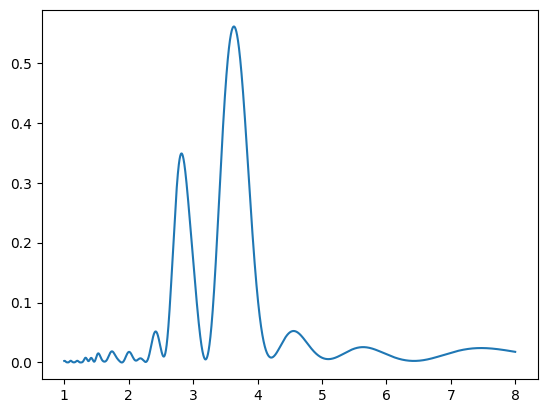

In [ ]:
import matplotlib.pyplot as plt
#2.4～3.0を1000等分して、その中のどれが自転周期なのかを探す
frequency = 1/np.linspace(1.0,8.0,10000)
total_power = np.array([])
for  detector in detectors.values():
    total_power = np.append(
        total_power, detector.power
    )
period = 1/frequency
plt.plot(period, detectors["detector_s0027"].power)

In [ ]:
total_bjd = np.array([])
total_flux = np.array([])*100-100
for  detector in detectors.values():
    total_bjd = np.append(
        total_bjd, detector.tessBJD
    )
    total_flux = np.append(
        total_flux, detector.mPDCSAPflux
    )

diff_bjd = np.diff(total_bjd)
gap_indices = np.where(diff_bjd >= 0.2)[0]

fig = make_subplots(rows=1, cols=1)

for i in range(len(gap_indices)):
    exclude_index = gap_indices[i]
    total_bjd[exclude_index] = np.nan
    total_flux[exclude_index] = np.nan
    fig.add_trace(
    go.Scatter(
        x=[total_bjd[exclude_index]],
        y=[total_flux[exclude_index]],
        mode="markers",
        marker=dict(color="blue", size=1),
        name="Excluded Point"
    ),
    row=1,
    col=1,
    )

fig.add_trace(
    go.Scatter(
        x=total_bjd,
        y=total_flux,
        mode="lines",
        line=dict(color="blue", width=1),
        name="Flux Line"
    ),
    row=1,
    col=1,
)

fig.update_layout(
    xaxis_range = [1850,2000],

    xaxis_title={
        'text':"時間(日)",
        'font':{
            'size':  50
        }
    },
    yaxis_title={
        'text':"平均の明るさに対する明るさ(%)",
        'font':{
            'size':  35
        }
    },
    xaxis={
        'tickfont': {
            'size': 30
        }
    },

    yaxis={
        'tickfont': {
            'size': 30
        }
    },
    showlegend=False,
    height=500,width=1700
)

fig.show()

In [ ]:
time = detectors["detector_s0049"].tessBJD
flux = detectors["detector_s0049"].mPDCSAPflux*100

diff_bjd = np.diff(detectors["detector_s0049"].tessBJD)
gap_indices = np.where(diff_bjd >= 0.2)[0]

time_excluded = time.copy()
flux_excluded = flux.copy()

fig = make_subplots(rows=1, cols=1)

for i in range(len(gap_indices)):
    exclude_index = gap_indices[i]
    time_excluded[exclude_index] = np.nan
    flux_excluded[exclude_index] = np.nan
    fig.add_trace(
    go.Scatter(
        x=[time[exclude_index]],
        y=[flux[exclude_index]],
        mode="markers",
        marker=dict(color="blue", size=1),
        name="Excluded Point"
    ),
    row=1,
    col=1,
    )

fig.add_trace(
    go.Scatter(
        x=time_excluded,
        y=flux_excluded,
        mode="lines",
        line=dict(color="blue", width=1),
        name="Flux Line"
    ),
    row=1,
    col=1,
)

fig.update_layout(

    xaxis_title={
        'text':"時間(日)",
        'font':{
            'size':  50
        }
    },
    yaxis_title={
        'text':"平均の明るさに対する割合(%)",
        'font':{
            'size':  40
        }
    },
    xaxis={
        'tickfont': {
            'size': 30
        }
    },

    yaxis={
        'tickfont': {
            'size': 30
        }
    },
    showlegend=False,
    title=dict(text="図1. EK Draの明るさの変動", font=dict(size=40) ,x=0.5,y=0.94 ),
    height=700,width=1300
)

fig.show()


In [ ]:
time = detectors["detector_s0049"].tessBJD
flux = detectors["detector_s0049"].s2mPDCSAPflux

diff_bjd = np.diff(detectors["detector_s0049"].tessBJD)
gap_indices = np.where(diff_bjd >= 0.2)[0]

time_excluded = time.copy()
detrended_flux_excluded = flux.copy()

fig = make_subplots(rows=1, cols=1)

for i in range(len(gap_indices)):
    exclude_index = gap_indices[i]
    time_excluded[exclude_index] = np.nan
    detrended_flux_excluded[exclude_index] = np.nan
    fig.add_trace(
    go.Scatter(
        x=[time[exclude_index]],
        y=[flux[exclude_index]],
        mode="markers",
        marker=dict(color="blue", size=1),
        name="Excluded Point"
    ),
    row=1,
    col=1,
    )

fig.add_trace(
    go.Scatter(
        x=time_excluded-2658.52,
        y=detrended_flux_excluded,
        mode="lines",
        line=dict(color="blue", width=7),
        name="Flux Line"
    ),
    row=1,
    col=1,
)



# if detectors["detector_s0049"].peaktime is not None:
#                 for peak in detectors["detector_s0049"].peaktime:
#                     fig.add_trace(
#                         go.Scatter(
#                             x=[peak, peak],
#                             y=[0.013, 0.0135],
#                             mode="lines",
#                             line=dict(color="red", width=5, dash="dash"),
#                             showlegend=False,
#                         ),
#                         row=1,
#                         col=1,
#                     )
fig.update_layout(
    # xaxis_title={
    #     'text':"時間(日)",
    #     'font':{
    #         'size':  50
    #     }
    # },
    # yaxis_title={
    #     'text':"明るさ",
    #     'font':{
    #         'size':  50
    #     }
    # },
    xaxis_range=[0,0.14],
    xaxis={
        'tickfont': {
            'size': 30
        }
    },

    yaxis={
        'tickfont': {
            'size': 30
        }
    },
    showlegend=False,
    title=dict(text="図2.フレア発生部分", font=dict(size=60) ,x=0.5, y=0.96 ),
    height=700,width=1300
)
fig.show()

In [ ]:
# plot_energy() メソッドでエネルギーをプロット
for  detector in detectors.values():
  detector.plot_flare()
  detector.plot_energy()

In [ ]:
# 気になった値について、plotly_expressを使ってプロットする
# 配列の要素数に注意する必要が多分ある。
# s2mPDCSAPflux をプロット
for name, instance in detectors.items():
  # print(instance.tessBJD)
  # print(instance.s2mPDCSAPflux)
  fig = px.scatter(
    x=instance.tessBJD,
    y=instance.s2mPDCSAPflux,
    title=f"TESS BJD vs PDCSAP Flux ({name})",
    labels={"x": "TESS BJD", "y": "PDCSAP Flux"}
  )
  fig.update_traces(marker=dict(size=1), name="Flux Data")
  fig.update_layout(showlegend=True)
  fig.show()

In [ ]:
# クラス変数は`クラス名.変数名`でアクセスできる
# print(f"フレア検出割合の配列{FlareDetector.array_flare_ratio}")
# print(f"観測時間の配列{FlareDetector.array_observation_time}")

fig = px.scatter(
  x=FlareDetector.array_observation_time,
  y=FlareDetector.array_flare_ratio,
  title=f"フレア検出割合の時間変化",
  labels={"x": "観測時間", "y": "フレア検出割合"},
  hover_data={"データ": list(FlareDetector.array_data_name)} # ホバーした時にデータ名が表示されるようにする
)
fig.update_traces(marker=dict(size=10), name="Flare Ratio")
fig.update_layout(showlegend=True)
fig.show()
# print(detectors["detector_s0021"].tessBJD)

In [ ]:
fig = px.scatter(
  x=FlareDetector.array_observation_time,
  y=FlareDetector.array_amplitude,
  title=f"明るさの振幅の時間変化",
  labels={"x": "観測時間", "y": "明るさの振幅"}
)

fig.update_traces(marker=dict(size=10), name="Flare Amplitude")
fig.update_layout(showlegend=True)
fig.show()

In [ ]:
# 簡易版
# px.scatter(x=FlareDetector.array_amplitude, y=FlareDetector.array_flare_ratio).show()

fig = px.scatter(
  x=FlareDetector.array_amplitude,
  y=FlareDetector.array_flare_ratio,
  labels={"x": "明るさの振幅(黒点面積)", "y": "フレアの数/日"},
  hover_data={"データ": list(FlareDetector.array_data_name)} # ホバーした時にデータ名が表示されるようにする
)

#フィッティング
coeffs = np.polyfit(FlareDetector.array_amplitude,FlareDetector.array_flare_ratio,1)
linear_fit = np.poly1d(coeffs)

fit_y = linear_fit(FlareDetector.array_amplitude)

fig.add_scatter(x=FlareDetector.array_amplitude, y=fit_y, mode='lines', name='線形フィッティング線', line=dict(width=5))

fig.update_traces(marker=dict(size=10), name="Flare Amplitude")
fig.update_layout(
    xaxis_title={
        'text':"明るさの変動(黒点面積)",
        'font':{
            'size':  40
        }
    },
    yaxis_title={
        'text':"フレアの数/日(個)",
        'font':{
            'size':  40
        }
    },
    xaxis={
        'tickfont': {
            'size': 25
        }
    },

    yaxis={
        'tickfont': {
            'size': 30
        }
    },
    showlegend=False,
    title=dict(text="図3.黒点面積とフレアの発生頻度の関係", font=dict(size=35) ,x=0.5 , y=0.97),
    height=700,width=1000
  )
fig.show()

In [ ]:
fig = px.scatter(
  x=FlareDetector.array_observation_time,
  y=FlareDetector.array_per,
  title=f"自転周期の時間変化",
  labels={"x": "観測時間", "y": "自転の周期"},
  hover_data={"データ": list(FlareDetector.array_data_name)} # ホバーした時にデータ名が表示されるようにする
)
#誤差バーを追加
fig.update_traces(
    marker=dict(size=10),
    name="Flare Amplitude",
    error_y=dict(
        type='data',
        array=FlareDetector.array_per_err,
        visible=True
    )
)
#フィッティング
def poly_fit(x,coeffs):
    p= Polynomial(coeffs)
    return p(x)

poly_coeff = Polynomial.fit(FlareDetector.array_observation_time, FlareDetector.array_per , 3).convert().coef

fit_y = poly_fit(FlareDetector.array_observation_time, poly_coeff)

fig.add_scatter(x=FlareDetector.array_observation_time, y=fit_y, mode='lines', name='フィッティング線')

fig.update_traces(marker=dict(size=10), name="Flare Amplitude")
fig.update_layout(showlegend=True, height=700,width=1000)
fig.show()

In [ ]:
fig = px.scatter(
  x=FlareDetector.array_amplitude,
  y=FlareDetector.array_energy_ratio,
  title=f"黒点面積とフレアエネルギー",
  labels={"x": "黒点面積", "y": "フレアのエネルギーの合計"}
)

coeffs = np.polyfit(FlareDetector.array_amplitude,FlareDetector.array_energy_ratio,1)
linear_fit = np.poly1d(coeffs)

fit_y = linear_fit(FlareDetector.array_amplitude)

fig.add_scatter(x=FlareDetector.array_amplitude, y=fit_y, mode='lines', name='線形フィッティング線', line=dict(width=5))

fig.update_traces(marker=dict(size=10), name="Flare Amplitude")
fig.update_layout(
    xaxis_title={
        'text':"明るさの変動(黒点面積)",
        'font':{
            'size':  40
        }
    },
    yaxis_title={
        'text':"フレアのエネルギーの合計(erg/日)",
        'font':{
            'size':  40
        }
    },
    xaxis={
        'tickfont': {
            'size': 25
        }
    },

    yaxis={
        'tickfont': {
            'size': 30
        }
    },
    showlegend=False,
    #title=dict(text="図3.黒点面積とフレアの発生頻度の関係", font=dict(size=35) ,x=0.5 , y=0.97),
    height=700,width=1000
  )

fig.update_traces(marker=dict(size=10), name="Flare Amplitude")
fig.update_layout(showlegend=True, height=700,width=1000)
fig.show()

In [ ]:
fig = px.scatter(
  x=FlareDetector.array_amplitude,
  y=FlareDetector.array_energy_ratio/FlareDetector.array_flare_ratio,
  title=f"黒点面積とフレアエネルギー",
  labels={"x": "黒点面積", "y": "フレア1つあたりのエネルギー"}
)

coeffs = np.polyfit(FlareDetector.array_amplitude,FlareDetector.array_energy_ratio/FlareDetector.array_flare_ratio,1)
linear_fit = np.poly1d(coeffs)

fit_y = linear_fit(FlareDetector.array_amplitude)

fig.add_scatter(x=FlareDetector.array_amplitude, y=fit_y, mode='lines', name='線形フィッティング線', line=dict(width=5))

fig.update_traces(marker=dict(size=10), name="Flare Amplitude")
fig.update_layout(
    xaxis_title={
        'text':"明るさの変動(黒点面積)",
        'font':{
            'size':  40
        }
    },
    yaxis_title={
        'text':"フレア1つあたりのエネルギー(erg)",
        'font':{
            'size':  40
        }
    },
    xaxis={
        'tickfont': {
            'size': 25
        }
    },

    yaxis={
        'tickfont': {
            'size': 30
        }
    },
    showlegend=False,
    #title=dict(text="図3.黒点面積とフレアの発生頻度の関係", font=dict(size=35) ,x=0.5 , y=0.97),
    height=700,width=1000
  )

fig.update_traces(marker=dict(size=10), name="Flare Amplitude")
fig.update_layout(showlegend=True, height=700,width=1000)
fig.show()
print(f"{FlareDetector.array_energy_ratio}/{FlareDetector.array_flare_ratio}={FlareDetector.array_energy_ratio/FlareDetector.array_flare_ratio}")

In [ ]:
fig = px.scatter(
  x=FlareDetector.array_flare_ratio,
  y=FlareDetector.array_energy_ratio,
  title=f"フレア頻度とフレアエネルギー",
  labels={"x": "フレア頻度", "y": "フレアのエネルギーの合計"}
)

coeffs = np.polyfit(FlareDetector.array_flare_ratio,FlareDetector.array_energy_ratio,1)
linear_fit = np.poly1d(coeffs)

fit_y = linear_fit(FlareDetector.array_flare_ratio)

fig.add_scatter(x=FlareDetector.array_flare_ratio, y=fit_y, mode='lines', name='線形フィッティング線', line=dict(width=5))

fig.update_traces(marker=dict(size=10), name="Flare Amplitude")
fig.update_layout(
    xaxis_title={
        'text':"フレア頻度",
        'font':{
            'size':  40
        }
    },
    yaxis_title={
        'text':"フレアのエネルギーの合計(erg/日)",
        'font':{
            'size':  40
        }
    },
    xaxis={
        'tickfont': {
            'size': 25
        }
    },

    yaxis={
        'tickfont': {
            'size': 30
        }
    },
    showlegend=False,
    #title=dict(text="図3.黒点面積とフレアの発生頻度の関係", font=dict(size=35) ,x=0.5 , y=0.97),
    height=700,width=1000
  )

fig.update_traces(marker=dict(size=10), name="Flare Amplitude")
fig.update_layout(showlegend=True, height=700,width=1000)
fig.show()

In [ ]:
fig = px.scatter(
  x=FlareDetector.array_per,
  y=FlareDetector.array_flare_ratio,
  title=f"自転周期とフレアの数",
  labels={"x": "自転周期", "y": "フレアの数"}
)

fig.update_traces(marker=dict(size=10), name="Flare Amplitude")
fig.update_layout(showlegend=True, height=700,width=1000)
fig.show()

In [ ]:
fig = px.scatter(
  x=FlareDetector.array_per,
  y=FlareDetector.array_amplitude,
  labels={"x": "自転周期", "y": "明るさの振幅(黒点面積)"}
)
fig.update_traces(
    marker=dict(size=10),
    name="Flare Amplitude",
    error_x=dict(
        type='data',
        array=FlareDetector.array_per_err,
        visible=True,
        color="blue",
        thickness=1
    )
)

fig.update_traces(marker=dict(size=10,color="red"), name="Flare Amplitude")
fig.update_layout(
    xaxis_title={
        'text':"自転周期(日)",
        'font':{
            'size':  40
        }
    },
    yaxis_title={
        'text':"明るさの変動(黒点面積)",
        'font':{
            'size':  40
        }
    },
    xaxis={
        'tickfont': {
            'size': 30
        }
    },

    yaxis={
        'tickfont': {
            'size': 30
        }
    },
    showlegend=False,
    title=dict(text="図4.自転周期と黒点面積の関係", font=dict(size=40) ,x=0.5,y=0.97 ),
    height=700,width=1300
)
fig.show()


In [ ]:
energy_ave = [a/b for a,b in zip(FlareDetector.array_energy_ratio,FlareDetector.array_flare_ratio)]
fig = px.scatter(
  x=FlareDetector.array_amplitude,
  y=energy_ave,
  labels={"x": "明るさの振幅(黒点面積)", "y": "フレアの数/日"},
  hover_data={"データ": list(FlareDetector.array_data_name)} # ホバーした時にデータ名が表示されるようにする
)

#フィッティング
coeffs = np.polyfit(FlareDetector.array_amplitude,energy_ave,1)
linear_fit = np.poly1d(coeffs)

fit_y = linear_fit(FlareDetector.array_amplitude)

fig.add_scatter(x=FlareDetector.array_amplitude, y=fit_y, mode='lines', name='線形フィッティング線')

fig.update_traces(marker=dict(size=10), name="Flare Amplitude")
fig.update_layout(
    xaxis_title={
        'text':"明るさの変動(黒点面積)",
        'font':{
            'size':  50
        }
    },
    yaxis_title={
        'text':"フレアの平均エネルギー",
        'font':{
            'size':  50
        }
    },
    xaxis={
        'tickfont': {
            'size': 25
        }
    },

    yaxis={
        'tickfont': {
            'size': 30
        }
    },
    showlegend=False,
    height=700,width=1000
  )
fig.show()

In [ ]:
# energy_ave = [a/b for a,b in zip(FlareDetector.array_energy_ratio,FlareDetector.array_flare_ratio)]
# energy_ave[8] = np.nan
# FlareDetector.array_amplitude[8] = np.nan
# amplitude_clean = []
# energy_clean = []
# data_name_clean = []

# for i in range(len(FlareDetector.array_amplitude)):
#     if not np.isnan(FlareDetector.array_amplitude[i]) and not np.isnan(energy_ave[i]):
#         amplitude_clean.append(FlareDetector.array_amplitude[i])
#         energy_clean.append(energy_ave[i])
#         data_name_clean.append(FlareDetector.array_data_name[i])
# fig = px.scatter(
#   x=amplitude_clean,
#   y=energy_clean,
#   labels={"x": "明るさの振幅(黒点面積)", "y": "フレアの数/日"},
#   hover_data={"データ": list(data_name_clean)} # ホバーした時にデータ名が表示されるようにする
# )

# #フィッティング
# coeffs = np.polyfit(amplitude_clean,energy_clean,1)
# linear_fit = np.poly1d(coeffs)

# fit_y = linear_fit(amplitude_clean)

# fig.add_scatter(x=amplitude_clean, y=fit_y, mode='lines', name='線形フィッティング線')

# fig.update_traces(marker=dict(size=10), name="Flare Amplitude")
# fig.update_layout(
#     yaxis_range = [5e33,5e34],
#     xaxis_title={
#         'text':"明るさの振幅(黒点面積)",
#         'font':{
#             'size':  50
#         }
#     },
#     yaxis_title={
#         'text':"フレアの平均エネルギー",
#         'font':{
#             'size':  50
#         }
#     },
#     xaxis={
#         'tickfont': {
#             'size': 25
#         }
#     },

#     yaxis={
#         'tickfont': {
#             'size': 30
#         }
#     },
#     showlegend=False,
#     height=700,width=1000
#   )
# fig.show()

In [ ]:
max_energy = np.array([])
for  detector in detectors.values():
    energy_cor=np.sort(detector.energy)
    max_energy = np.append(
        max_energy, energy_cor[-1]
    )
    max_energy = np.append(
        max_energy, energy_cor[-2]
    )
amplitudes = np.repeat(FlareDetector.array_amplitude, 2)
fig = px.scatter(
  x=amplitudes,
  y=max_energy,
  labels={"x": "明るさの振幅(黒点面積)", "y": "top2フレアのエネルギー"},
  #hover_data={"データ": list(FlareDetector.array_data_name)} # ホバーした時にデータ名が表示されるようにする
)
fig.update_traces(marker=dict(size=10), name="Flare Energy")
fig.update_layout(showlegend=True)
fig.show()

In [ ]:
max_energy = np.array([])
for  detector in detectors.values():
    energy_cor=np.sort(detector.energy)
    ave_max2_ene = (energy_cor[-1]+energy_cor[-2])/2
    max_energy = np.append(
        max_energy, ave_max2_ene
    )
fig = px.scatter(
  x=FlareDetector.array_amplitude,
  y=max_energy,
  labels={"x": "明るさの振幅(黒点面積)", "y": "top2フレアの平均エネルギー"},
  hover_data={"データ": list(FlareDetector.array_data_name)} # ホバーした時にデータ名が表示されるようにする
)
fig.update_traces(marker=dict(size=10), name="Flare Energy")
fig.update_layout(showlegend=True)
fig.show()

In [ ]:
max_energy = np.array([])
for  detector in detectors.values():
    energy_cor=np.sort(detector.energy)
    max_energy = np.append(
        max_energy, energy_cor[-1]
    )
fig = px.scatter(
  x=FlareDetector.array_amplitude,
  y=max_energy,
  labels={"x": "明るさの振幅(黒点面積)", "y": "フレアの最大エネルギー"},
  hover_data={"データ": list(FlareDetector.array_data_name)} # ホバーした時にデータ名が表示されるようにする
)
fig.update_traces(marker=dict(size=10), name="Flare Energy")
fig.update_layout(showlegend=True)
fig.show()


In [ ]:
min_energy = np.array([])
for  detector in detectors.values():
    energy_cor=np.sort(detector.energy)
    min_energy = np.append(
        min_energy, energy_cor[0]
    )
fig = px.scatter(
  x=FlareDetector.array_amplitude,
  y=min_energy,
  labels={"x": "明るさの振幅(黒点面積)", "y": "フレアの最小エネルギー"},
  hover_data={"データ": list(FlareDetector.array_data_name)} # ホバーした時にデータ名が表示されるようにする
)
fig.update_traces(marker=dict(size=10), name="Flare Energy")
fig.update_layout(showlegend=True)
fig.show()


In [ ]:
min_energy = np.array([])
for  detector in detectors.values():
    energy_cor=np.sort(detector.energy)
    min_energy = np.append(
        min_energy, energy_cor[0]
    )
max_energy = np.array([])
for  detector in detectors.values():
    energy_cor=np.sort(detector.energy)
    max_energy = np.append(
        max_energy, energy_cor[-1]
    )
fig = px.scatter(
  x=max_energy,
  y=min_energy,
  labels={"x": "フレアの最大エネルギー", "y": "フレアの最小エネルギー"},
  hover_data={"データ": list(FlareDetector.array_data_name)} # ホバーした時にデータ名が表示されるようにする
)

coeffs = np.polyfit(max_energy,min_energy,1)
linear_fit = np.poly1d(coeffs)

fit_y = linear_fit(max_energy)

fig.add_scatter(x=max_energy, y=fit_y, mode='lines', name='線形フィッティング線')

fig.update_traces(marker=dict(size=10), name="Flare Energy")
fig.update_layout(showlegend=True, height=1000,width=1000)
fig.show()

In [ ]:
detectors["detector_s0016"].sum_flare_energy

### 作るの遅れてごめん。わからんとこあったらいつでも聞いて〜

あとは、前大治郎が言ってたみたいに、明らかにミスって検出しているところを修正できるように flarepy_improved.py 内の関数を修正したい。
